
# Analysis Notebook

This notebook can be used to produce graphs and analyses for the data produced. It defaults to using the latest results, but that can be specified. 
*** 

## 0. Setup <a class="anchor" id="0"></a>
This section imports all files and sets up the notebook.

In [164]:
# Import all pacakges
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [165]:
# Choose which results to use
results_to_use = [""]  # If this is empty, all files in the folder will be used
WARMUP_EPOCHS = 0 # Number of epochs to ignore.
sim_colours = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']


all_results = os.listdir('results/')

if results_to_use == [""]:
    results_to_use = all_results
# remove DS_Store from the list
if '.DS_Store' in results_to_use:
    results_to_use.remove('.DS_Store')
    
print("Using results: " + str(results_to_use))


Using results: ['random', 'adaptive']


In [166]:
# Create a dictionary. Each key is a set of results. 

all_sim_results = {}

for sim in results_to_use:
    all_sim_results[sim] = {}
    all_sim_results[sim]['configuration'] = pd.read_csv(
        'results/' + sim + '/configuration.txt', header=None, delimiter=":")
    types_of_results = []
    # Get all the filenames in the folder, excluding the extension
    for file in os.listdir('results/' + sim + '/exported_data/'):
        if file.endswith(".npy"):
            types_of_results.append(file[:-4])
    # Create a dictionary for each type of result
    for result in types_of_results:
        all_sim_results[sim][result] = np.load(
            'results/' + sim + '/exported_data/' + result + '.npy')

In [167]:
# Show all the all_sim_results in the notebook
for set_of_results in results_to_use:
    print("Results: " + set_of_results)
    print(all_sim_results[set_of_results]['configuration'])

Results: random
                                    0                   1
0                             command                 run
1                       num_of_epochs                1000
2                  num_of_simulations                  10
3                           grid_size                   3
4                      queue_capacity                  10
5                     congestion_rate                0.07
6                       with_hotspots                True
7                           wage_time                  10
8                      credit_balance                   5
9           shared_auction_parameters                None
10  adaptive_auction_action_selection              random
11               bid_calculation_rule              linear
12       adaptive_auction_update_rule       simple_bandit
13             auction_episode_length                  10
14   action_selection_hyperparameters                None
15    adaptive_auction_discretization                  2

## 1. Average Trip Satisfaction  <a class="anchor" id="1"></a>

<Figure size 640x480 with 0 Axes>

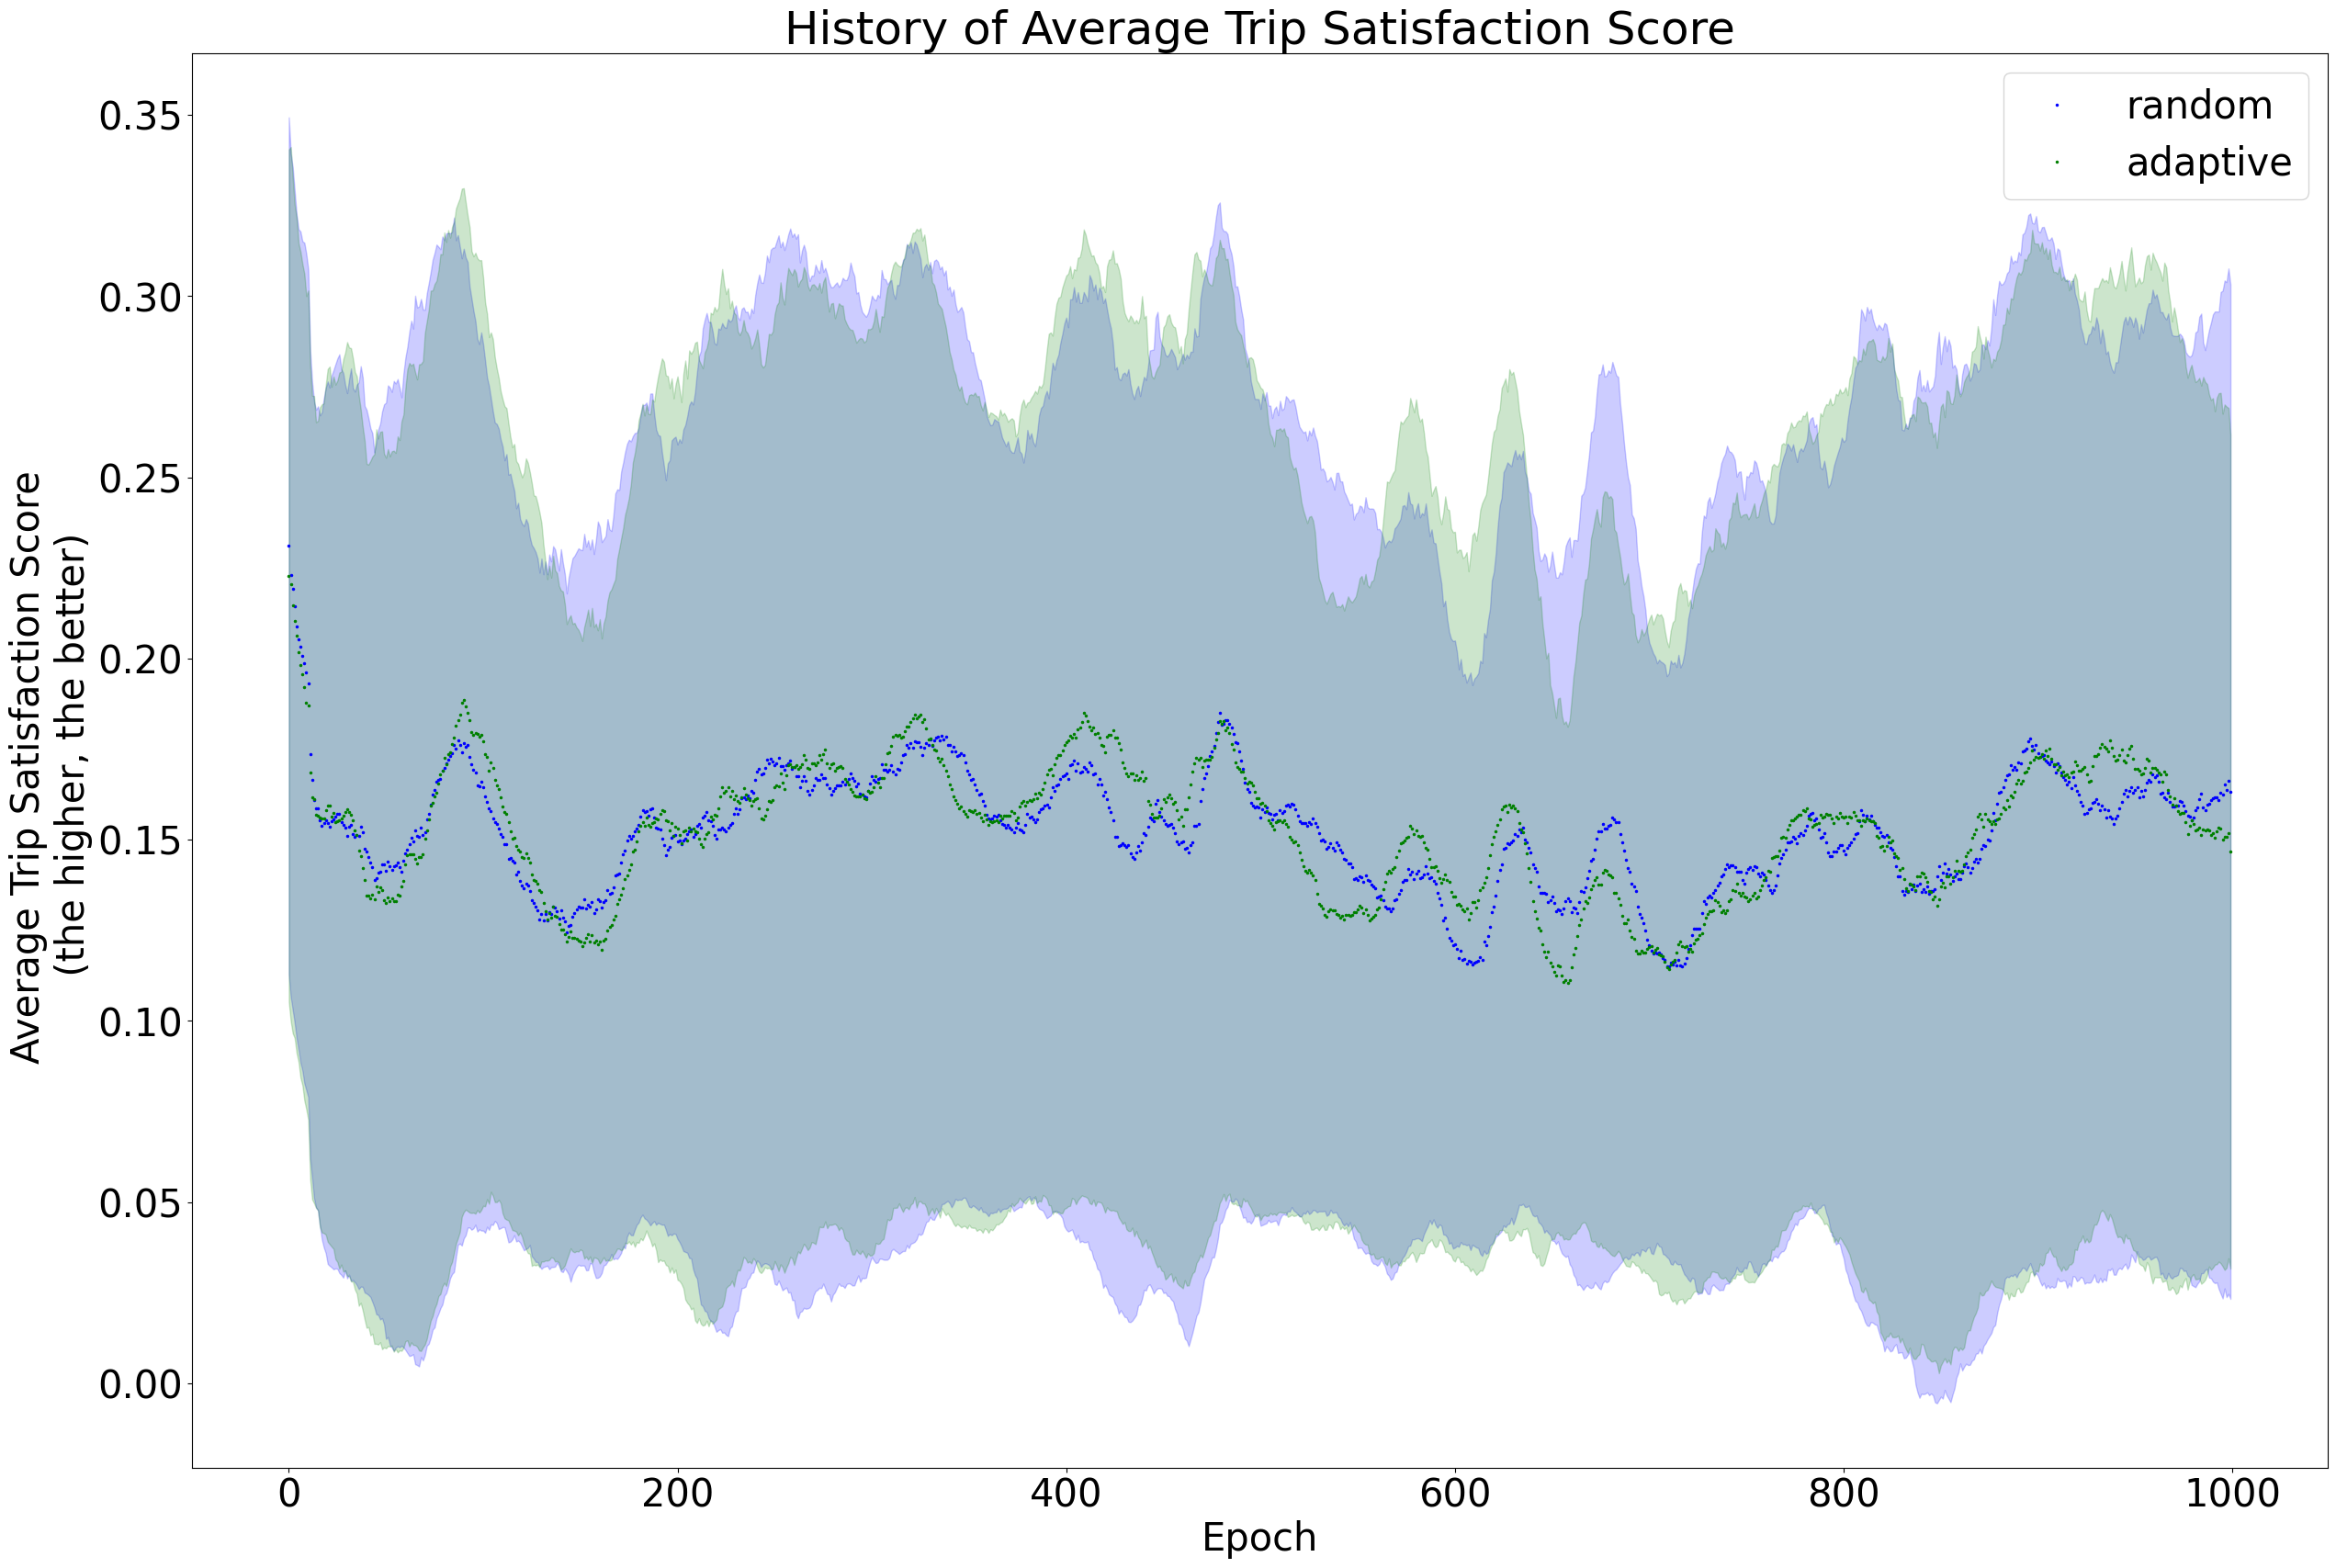

In [168]:
plt.clf()

average_satisfaction_score_results = []
std_satisfaction_score_results = []

for sim in results_to_use:
    average_satisfaction_score_results.append(
        all_sim_results[sim]['average_satisfaction_score'])

for sim in results_to_use:
    std_satisfaction_score_results.append(
        all_sim_results[sim]['std_satisfaction_score'])

for i, history in enumerate(average_satisfaction_score_results):
    average_satisfaction_score_results[i] = history[WARMUP_EPOCHS:]
    std_satisfaction_score_results[i] = std_satisfaction_score_results[i][WARMUP_EPOCHS:]
plt.figure(figsize=(30, 20))
plt.rcParams.update({'font.size': 30})
for i, history in enumerate(average_satisfaction_score_results):
    plt.plot(list(range(len(history))), history,
             'o', ls='none', markersize=1.5, label=results_to_use[i], color=sim_colours[i])

for i, history in enumerate(std_satisfaction_score_results):
    plt.fill_between(list(range(len(average_satisfaction_score_results[i]))), average_satisfaction_score_results[
                     i] - history, average_satisfaction_score_results[i] + history, alpha=0.2, color=sim_colours[i], interpolate=True)
plt.xlabel('Epoch')
plt.ylabel('Average Trip Satisfaction Score \n (the higher, the better)')
plt.title('History of Average Trip Satisfaction Score')
plt.legend()
plt.show()


## 2. Average Auction Reward per Intersection

In [169]:
def plot_single_reward_history(average_reward_per_intersection, label, colour, axs):
    for i in range(average_reward_per_intersection.shape[0]):
        for j in range(average_reward_per_intersection.shape[0]):
            axs[i, j].plot(
                average_reward_per_intersection[i, j], 'o', markersize=1.5, color=colour, label=label)
            axs[i, j].set_title('[' + str(i) + ',' + str(j) + ']')
            axs[i, j].set_xlabel('Epoch')
            axs[i, j].set_ylabel('Average Auction Reward')
    

def plot_std_fill(avg_values, std_fill, colour, axs):
    for i in range(std_fill.shape[0]):
        for j in range(std_fill.shape[0]):
            axs[i, j].fill_between(list(range(len(avg_values[i, j]))), avg_values[i, j] - std_fill[i, j], avg_values[i, j] + std_fill[i, j], alpha=0.2, color=colour, interpolate=True)

<Figure size 640x480 with 0 Axes>

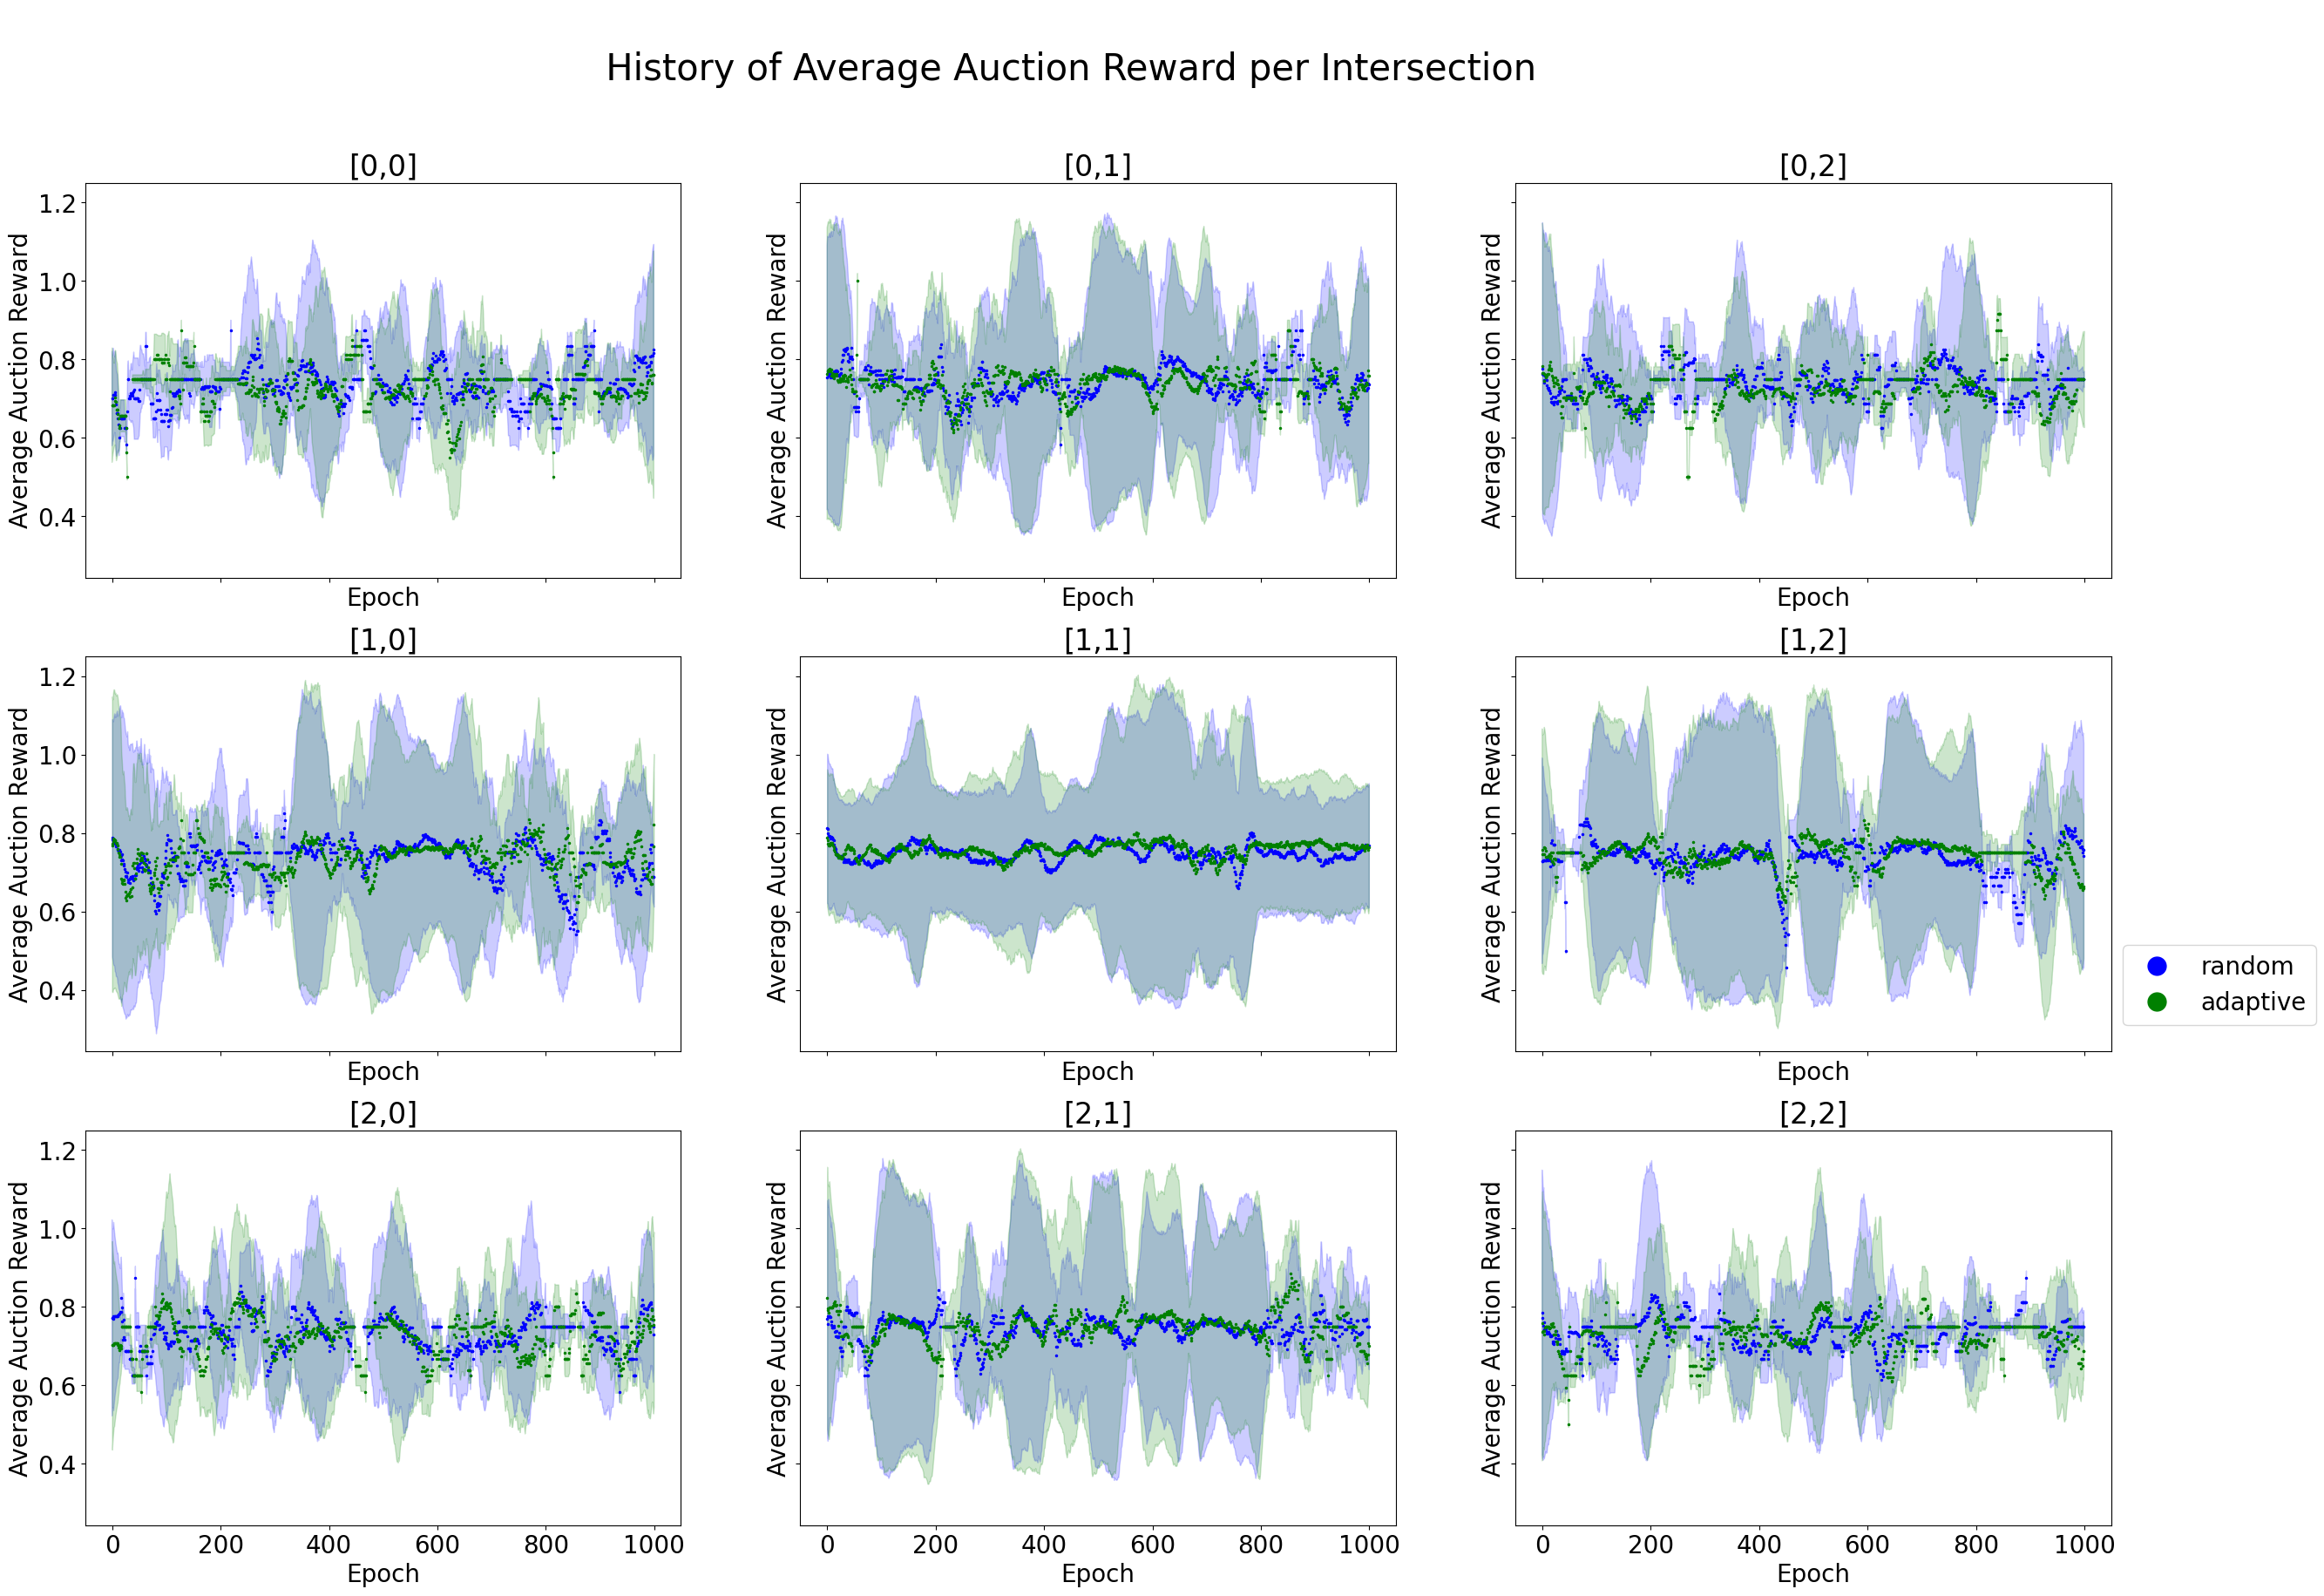

In [189]:
plt.clf()
average_reward_per_intersection_history_results = []
std_reward_per_intersection_history_results = []
for sim in results_to_use:
    average_reward_per_intersection_history_results.append(
        all_sim_results[sim]['average_reward_per_intersection_history'])

for sim in results_to_use:
    std_reward_per_intersection_history_results.append(
        all_sim_results[sim]['std_reward_per_intersection_history'])

plt.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(
    average_reward_per_intersection_history_results[0].shape[0],
    average_reward_per_intersection_history_results[0].shape[1], sharex=True, sharey=True, figsize=(30, 20))

for i, history in enumerate(average_reward_per_intersection_history_results):
    plot_single_reward_history(history, results_to_use[i], sim_colours[i], axs)
    
for i, history in enumerate(std_reward_per_intersection_history_results):    
    plot_std_fill(average_reward_per_intersection_history_results[i], std_reward_per_intersection_history_results[i], sim_colours[i], axs)

fig.suptitle(
    '\n History of Average Auction Reward per Intersection', fontsize=30)

plt.subplots_adjust(right=0.9)
lgnd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1.5), markerscale = 10)
plt.show()


## 3. Average Throughput per Intersection <a id="3"></a>

In [171]:
def plot_throughput_history(throughput_history_per_intersection, label, colour, axs):
    for i in range(throughput_history_per_intersection.shape[0]):
        for j in range(throughput_history_per_intersection.shape[0]):
            axs[i, j].plot(
                throughput_history_per_intersection[i, j], 'o', markersize=1.5, color=colour, label=label)
            axs[i, j].set_title('[' + str(i) + ',' + str(j) + ']')
            axs[i, j].set_xlabel('Epoch')
            axs[i, j].set_ylabel('Average Throughput')

<Figure size 640x480 with 0 Axes>

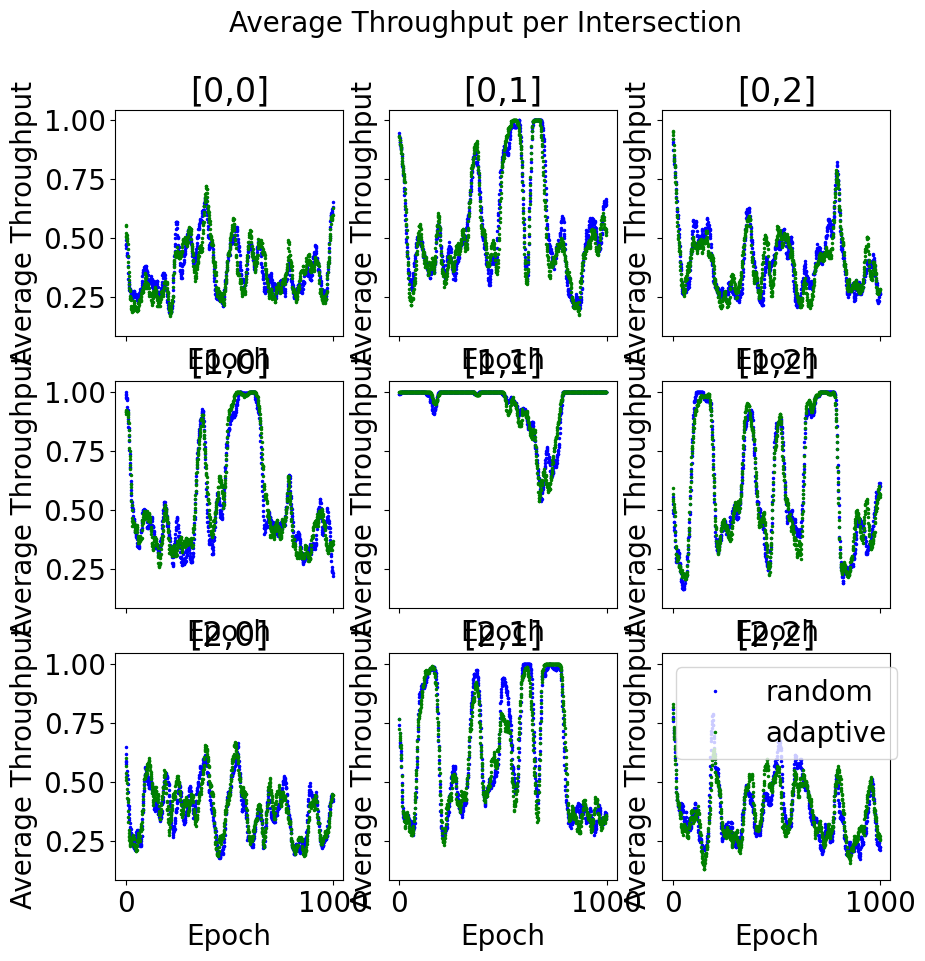

In [172]:
plt.clf()
average_throughput_per_intersection_history_results = []
for sim in results_to_use:
    average_throughput_per_intersection_history_results.append(
        all_sim_results[sim]['average_throughput_per_intersection'])

fig, axs = plt.subplots(
    average_throughput_per_intersection_history_results[0].shape[0], 
    average_throughput_per_intersection_history_results[0].shape[1], sharex=True, sharey=True, figsize=(10, 10))

for i, history in enumerate(average_throughput_per_intersection_history_results):
    plot_throughput_history(history, results_to_use[i], sim_colours[i], axs)

fig.suptitle('Average Throughput per Intersection ', fontsize=20)
plt.legend()
plt.show()


## 4. Average Max Time Waited per Intersection <a id="4"></a>

In [173]:
def plot_max_time_waited_history(max_time_waited_history_per_intersection, label, colour, axs):
    for i in range(max_time_waited_history_per_intersection.shape[0]):
        for j in range(max_time_waited_history_per_intersection.shape[0]):
            axs[i, j].plot(
                max_time_waited_history_per_intersection[i, j], 'o', markersize=1.5, color=colour, label=label)
            axs[i, j].set_title('[' + str(i) + ',' + str(j) + ']')
            axs[i, j].set_xlabel('Epoch')
            axs[i, j].set_ylabel('Average Max Time Waited')

<Figure size 640x480 with 0 Axes>

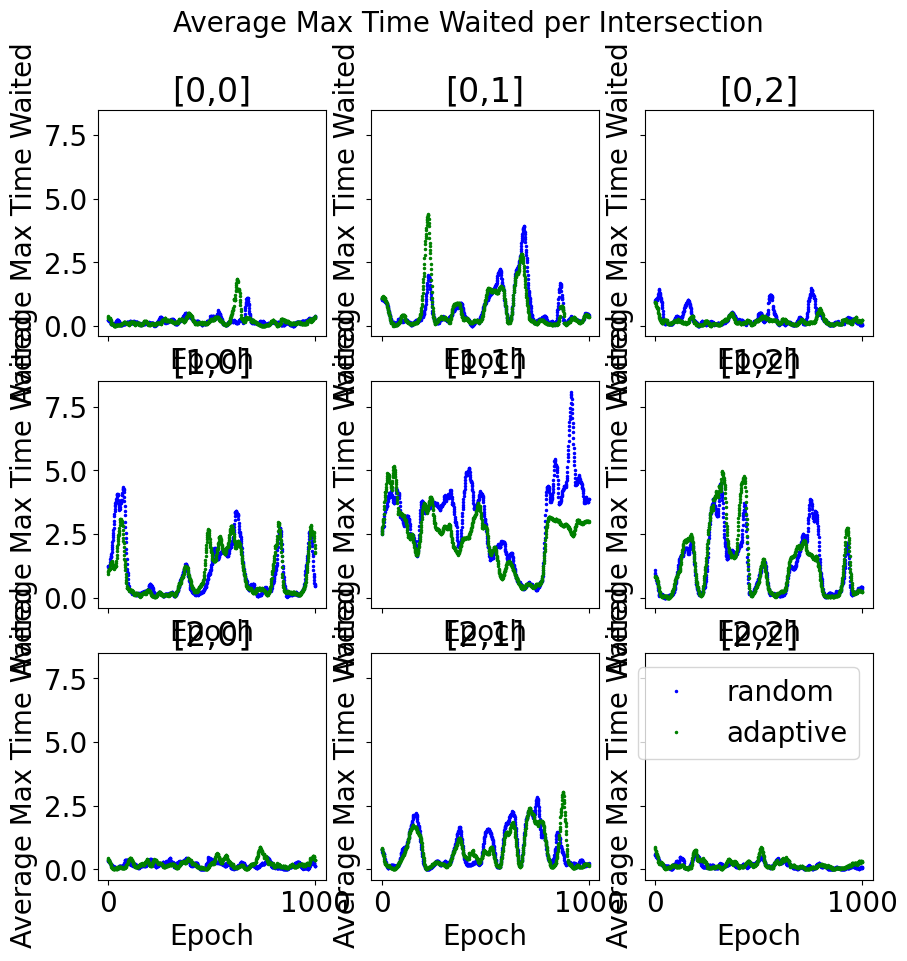

In [174]:
plt.clf()
average_max_time_waited_per_intersection_history_results = []
for sim in results_to_use:
    average_max_time_waited_per_intersection_history_results.append(
        all_sim_results[sim]['average_max_time_waited_per_intersection_history'])

fig, axs = plt.subplots(
    average_max_time_waited_per_intersection_history_results[0].shape[0], 
    average_max_time_waited_per_intersection_history_results[0].shape[1], sharex=True, sharey=True, figsize=(10, 10))

for i, history in enumerate(average_max_time_waited_per_intersection_history_results):
    plot_max_time_waited_history(history, results_to_use[i], sim_colours[i], axs)

fig.suptitle('Average Max Time Waited per Intersection ', fontsize=20)
plt.legend()
plt.show()


## 5. Average Gini (based on time waited) coefficient per Intersection <a id="5"></a>

In [175]:
def plot_gini_history(gini_history_per_intersection, label, colour, axs):
    for i in range(gini_history_per_intersection.shape[0]):
        for j in range(gini_history_per_intersection.shape[0]):
            axs[i, j].plot(
                gini_history_per_intersection[i, j], 'o', markersize=1.5, color=colour, label=label)
            axs[i, j].set_title('[' + str(i) + ',' + str(j) + ']')
            axs[i, j].set_xlabel('Epoch')
            axs[i, j].set_ylabel('Average Gini Coeff')

<Figure size 640x480 with 0 Axes>

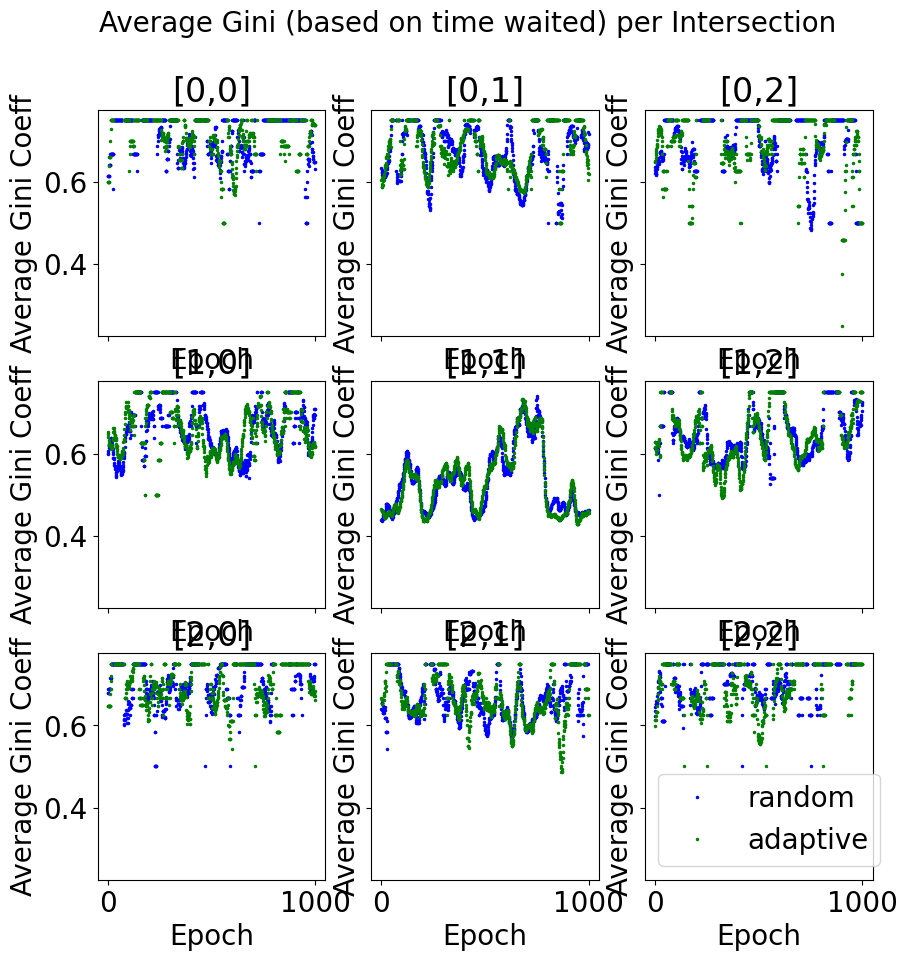

In [176]:
plt.clf()
average_gini_per_intersection_history_results = []
for sim in results_to_use:
    average_gini_per_intersection_history_results.append(
        all_sim_results[sim]['average_gini_time_waited_per_intersection_history'])

fig, axs = plt.subplots(
    average_gini_per_intersection_history_results[0].shape[0], 
    average_gini_per_intersection_history_results[0].shape[1], sharex=True, sharey=True, figsize=(10, 10))

for i, history in enumerate(average_gini_per_intersection_history_results):
    plot_gini_history(history, results_to_use[i], sim_colours[i], axs)

fig.suptitle('Average Gini (based on time waited) per Intersection ', fontsize=20)
plt.legend()
plt.show()


## 6. Average Parameter Valuations per Intersection <a id="5"></a>

In [177]:
def plot_average_valuation_per_parameter_per_intersection(rewards, parameters, counts, label, colour, axs):
    for i in range(rewards.shape[0]):
        for j in range(rewards.shape[0]):
            axs[i, j].scatter(
                parameters[:, 0], rewards[i, j, :], s=counts[i, j, :], marker="o", c=colour, label=label)
            axs[i, j].set_title('[' + str(i) + ',' + str(j) + ']')
            axs[i, j].set_xlabel('Delay Boost')
            axs[i, j].set_ylabel('Average Reward')

<Figure size 640x480 with 0 Axes>

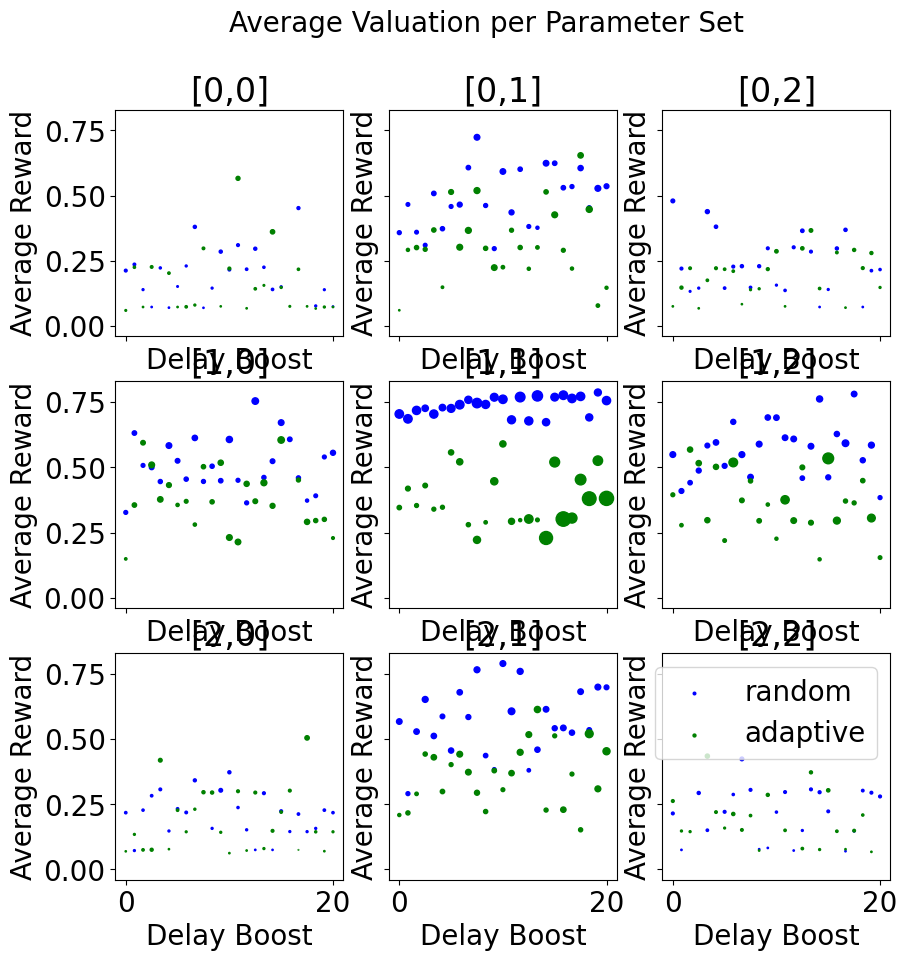

In [178]:
plt.clf()
average_valuations_per_parameter_per_intersection = []
parameters_used = []
counts_per_paramter = []
for sim in results_to_use:
    average_valuations_per_parameter_per_intersection.append(
        all_sim_results[sim]['average_reward_per_parameter_set_per_intersection_rewards'])
    parameters_used.append(
        all_sim_results[sim]['average_reward_per_parameter_set_per_intersection_parameters'])
    counts_per_paramter.append(
        all_sim_results[sim]['average_reward_per_parameter_set_per_intersection_counts'])


fig, axs = plt.subplots(
    average_valuations_per_parameter_per_intersection[0].shape[0],
    average_valuations_per_parameter_per_intersection[0].shape[1], sharex=True, sharey=True, figsize=(10, 10))

for i, reward_set in enumerate(average_valuations_per_parameter_per_intersection):
    plot_average_valuation_per_parameter_per_intersection(
        reward_set, parameters_used[i], counts_per_paramter[i],  results_to_use[i], sim_colours[i], axs)

fig.suptitle('Average Valuation per Parameter Set ', fontsize=20)
plt.legend()
plt.show()
